In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

import time

In [30]:
df_values = pd.read_csv('data/train_values.csv', index_col = 'building_id')
df_labels = pd.read_csv('data/train_labels.csv', index_col = 'building_id')

In [31]:
# The Secondary Uses of the building nor the ownership should have a factor in determining earthquake damage
# so removing them from our dataset made the most sense.
selected_features = df_values.columns[:25]
features_list = []

for feature in selected_features:
    features_list.append(feature)
    
train_values_subset = df_values[features_list]

In [32]:
data_viz = train_values_subset.join(df_labels)

### Because we are focused on the features of completely destroyed buildings, we grouped 'damage_grade' == 1 and 'damage_grade' == 2 as one category

In [33]:
def damage_classifier(val):
    if val == 3:
        return 1
    else:
        return 0
data_viz['damage_grade'] = data_viz['damage_grade'].map(damage_classifier)

In [34]:
major_damage = data_viz

In [35]:
data_viz.damage_grade.value_counts()

0    173383
1     87218
Name: damage_grade, dtype: int64

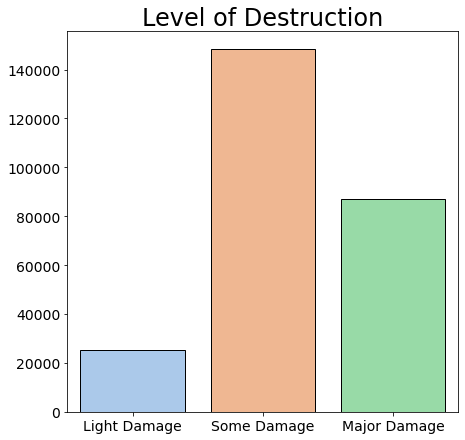

In [9]:
y = [25124, 148259, 87218]
x = ['Light Damage', 'Some Damage', 'Major Damage']

plt.figure(figsize=(7,7))
sns.barplot(x=x, y=y, edgecolor='black', palette='pastel')
plt.title('Level of Destruction', fontsize=24)
# plt.xlabel('', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

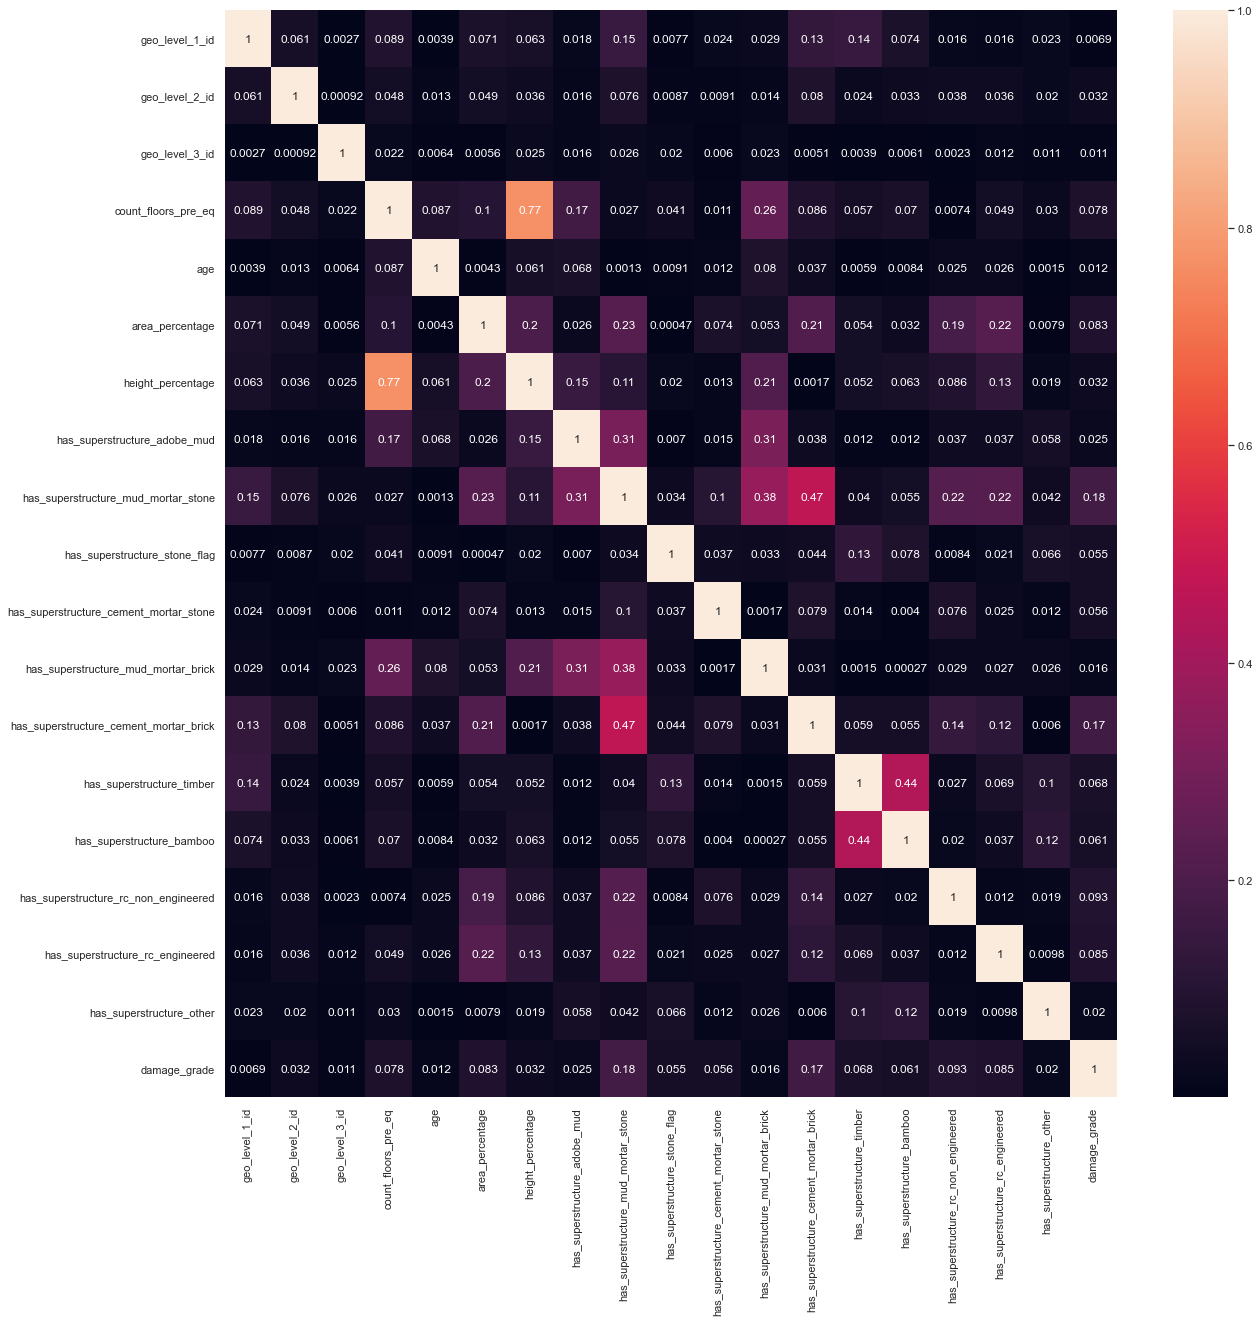

In [262]:
sns.set(rc={'figure.figsize':(20, 20)})
sns.heatmap(major_damage.corr().abs(),annot=True);

Because 'Height_percentage' and 'count_floors_pre_eq' are highly collinear with each other, we decided to drop 'count_floors_pre_eq' as 'height_percentage' is more useful in determining the overall height of a building.

In [36]:
major_damage = major_damage.drop('count_floors_pre_eq', axis = 1)

As Geographical location should not be a factor in predicting damage for future earthquakes (Focus on areas with tectonic plates),
as well as the position of the house (direction the house is facing), along with the plan configuration of the house, those features were left from our dataset.

In [37]:
major_damage = major_damage.drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'position', 'plan_configuration'], axis = 1)

# Feature Importance

For the remaining object types, we converted them into a categorical so we can pass the dataset into a StandardScaler to find the most important features

In [38]:
# 1 = flat, 2 = Moderate, 3 = steep
def foundation(val):
    if val == 'r':
        return 1
    elif val == 'u':
        return 2
    elif val == 'w':
        return 3
    elif val == 'h':
        return 4
    elif val == 'i':
        return 5

# 1 = flat, 2 = Moderate, 3 = steep
def land_type(val):
    if val == 't':
        return 1
    elif val == 'n':
        return 2
    else:
        return 3
    
# q = Reinforced cement concrete slabs, n = bamboo, x = other
def roof(val):
    if val == 'n':
        return 1
    elif val == 'q':
        return 2
    else:
        return 3
    
def floor_type(val):
    if val == 'f':
        return 1
    elif val == 'x':
        return 2
    elif val == 'v':
        return 3
    elif val == 'z':
        return 4
    elif val == 'm':
        return 5
    
def floor_type_2(val):
    if val == 'q':
        return 1
    elif val == 'x':
        return 2
    elif val == 'j':
        return 3
    elif val == 's':
        return 4

In [39]:
major_damage['foundation_type'] = major_damage['foundation_type'].map(foundation)
major_damage['land_surface_condition'] = major_damage['land_surface_condition'].map(land_type)
major_damage['roof_type'] = major_damage['roof_type'].map(roof)
major_damage['ground_floor_type'] = major_damage['ground_floor_type'].map(floor_type)
major_damage['other_floor_type'] = major_damage['other_floor_type'].map(floor_type_2)

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64

### After The Transformations, This Is The Dataset We Will Use to Determine Feature Importance.

In [56]:
major_damage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257250 entries, 802906 to 747594
Data columns (total 20 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   age                                     257250 non-null  int64
 1   area_percentage                         257250 non-null  int64
 2   height_percentage                       257250 non-null  int64
 3   land_surface_condition                  257250 non-null  int64
 4   foundation_type                         257250 non-null  int64
 5   roof_type                               257250 non-null  int64
 6   ground_floor_type                       257250 non-null  int64
 7   other_floor_type                        257250 non-null  int64
 8   has_superstructure_adobe_mud            257250 non-null  int64
 9   has_superstructure_mud_mortar_stone     257250 non-null  int64
 10  has_superstructure_stone_flag           257250 non-null  int64


In [ ]:
len(major_damage[major_damage['height_percentage'] > 11])

We noticed that 'height_percentage' is normalized, however there are values over 10, which would mean it is an input error. Because the size of the input errors are limited, we decided it best to drop them instead of guessing what the original value is.

In [49]:
major_damage = major_damage[major_damage['height_percentage'] < 11]

Save as a csv for ease of use in our modeling notebook

In [50]:
major_damage.to_csv('major_damage.csv')

### Train-Test Split For Feature Selection

In [51]:
X_train, X_test, y_train, y_test = train_test_split(major_damage.drop('damage_grade', axis=1), major_damage['damage_grade'], test_size=0.25, random_state=1)

In [52]:
# Instantiate Standard Scaler
ss = StandardScaler()
ss.fit(X_train)

# Transform both Train and Test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

## Using SelectKBest to Extract Important Features

In [59]:
X = major_damage.drop('damage_grade', axis = 1) 
y = major_damage['damage_grade'] 
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 10 best features

                                     Specs        Score
0                                      age  8334.750501
13  has_superstructure_cement_mortar_brick  6682.519045
4                          foundation_type  6055.587226
1                          area_percentage  3728.420160
6                        ground_floor_type  2491.266452


### SelectKBest determined features ['Age', 'has_superstructure_cement_mortar_brick', 'foundation_type', 'area_percentage'] as the most important features.

## Using Random Forest and Extra Trees Classifier To Determine Feature Importance

In [53]:
feature_names = [f"feature {i}" for i in range(X_train_scaled.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

In [54]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.086 seconds


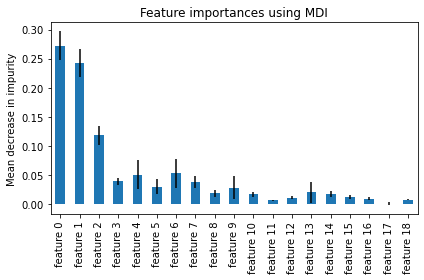

In [55]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Imputation to find most important features

In [57]:
start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 124.155 seconds


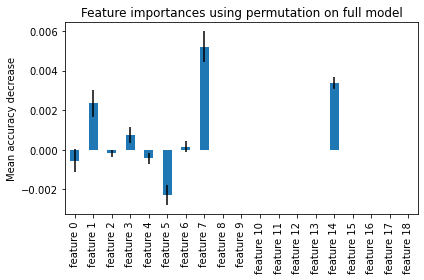

In [58]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Results were difficult to understand, so we left imputation and use the first graph for explainability.

### Random Forest Determined Features ['Age', 'Area_percentage', 'Height_percentage'] as highest important features.


### Extra Trees

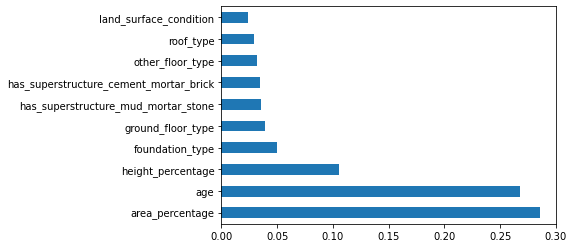

In [60]:
model = ExtraTreesClassifier()
model.fit(X,y)
#use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Extra Trees Classifier Determined Features ['Age', 'Area_percentage', Height_perentage'] as the most important features.

This follows logical sense as Random Forest and Extra Trees work essentially in the same way. Lets use one more estimator to help determine the most important features.

## Logistic Regression for Feature Importance

Feature: 0, Score: -0.00013
Feature: 1, Score: -0.01957
Feature: 2, Score: 0.07925
Feature: 3, Score: -0.05088
Feature: 4, Score: -0.54720
Feature: 5, Score: 0.09685
Feature: 6, Score: -0.23809
Feature: 7, Score: 0.11725
Feature: 8, Score: 0.14234
Feature: 9, Score: 0.31030
Feature: 10, Score: 0.79763
Feature: 11, Score: -0.35991
Feature: 12, Score: -0.07536
Feature: 13, Score: -1.25198
Feature: 14, Score: -0.25679
Feature: 15, Score: -0.25671
Feature: 16, Score: -0.29874
Feature: 17, Score: -0.16054
Feature: 18, Score: -0.12137


C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


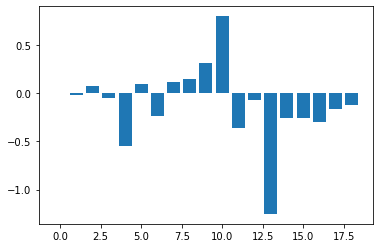

In [61]:
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show();

#### Features 11 and 14 have abnormally high and low scores, respectively. Feature 14, superstructure_cement_mortar_brick came up again from SelectKBest. Feature 11 was superstructure_stone_flag, if the structure had a superstructure made of stone.

In [287]:
major_damage['has_superstructure_cement_mortar_brick'].value_counts(normalize = True)

0    0.927615
1    0.072385
Name: has_superstructure_cement_mortar_brick, dtype: float64

In [288]:
major_damage['has_superstructure_stone_flag'].value_counts(normalize = True)

0    0.965629
1    0.034371
Name: has_superstructure_stone_flag, dtype: float64

### From this data, building's superstructure that were not made out of cement mortar - brick or stone, the building had a high likelyhood of being completely destroyed

## The Most Important Features Were The Buildings Age, Superstructure Type, and Height Percentage.